# Presentation Plots

## Imports

In [1]:
import os
import re

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FormatStrFormatter

IPython magic:

In [3]:
%matplotlib inline
plt.rcParams["figure.dpi"] = 600
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 11
})
%config InlineBackend.figure_formats = ['png']

## Constants

In [17]:
DATA_PATH = "data/"
FILES = os.listdir(DATA_PATH)
FILES_PATH = dict(zip([file.split('_')[-1][:-4] for  file in FILES],
                      [os.path.join(DATA_PATH, file) for file in FILES]))

In [18]:
FILES_PATH

{'weakscaling': 'data/s15-17_np1-16_weakscaling.csv',
 'strongscaling': 'data/s19_np1-16_strongscaling.csv',
 'comparison': 'data/s19_np8_comparison.csv',
 'growinggraph': 'data/s7-19_np8_growinggraph.csv'}

In [6]:
FIGSIZE = (8,6)

In [7]:
ALGORITHMS = {
    0 : "Distributed edges",
    1 : "Distributed edges w. pointer jumping",
    2 : "Distributed vertices",
    3 : "Distributed vertices w. pointer jumping",
    4 : "Distributed vertices w. pointer jumping & supervertices",
    5 : "Boost@1.78.0 (baseline)"}

In [106]:
LINE_STYLES = {
    0 : dict(linestyle='-', color='blue', linewidth=1.5,marker='x',mfc='none',markersize=5),
    1 : None,
    2 : dict(linestyle='-.', color='black', linewidth=1),
    3 : dict(linestyle=':', color='black', linewidth=1),
    4 : dict(linestyle='--', color='black', linewidth=1),
    5 : dict(linestyle='-', color='red', linewidth=1.5)}

In [121]:
BAR_STYLES = {
    0 : dict(edgecolor='blue', facecolor='white', hatch='\ ', linewidth=1.5),
    1 : None,
    2 : dict(linestyle='-.', edgecolor='black', facecolor='white', hatch='\ ', linewidth=1),
    3 : dict(linestyle=':', edgecolor='black', facecolor='white', hatch='\ ', linewidth=1),
    4 : dict(linestyle='--', edgecolor='black', facecolor='white', hatch='\ ', linewidth=1),
    5 : dict(edgecolor='red', facecolor='white', hatch='\ ', linewidth=1.5)}

## Functions

In [52]:
def double_std(array):
    return np.std(array) * 2

In [10]:
def tex_escape(text):
    """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(str(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

## 1. Strong Scaling

In [11]:
df_strongscaling = pd.read_csv(FILES_PATH['strongscaling'])
df_strongscaling.head(5)

,algorithm,cores,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10
0,0,1,0.70617,0.706512,0.704235,0.705656,0.703745,0.705371,0.704514,0.706113,0.70471,0.706488
1,0,2,0.39650,0.397500,0.398200,0.398500,0.399300,0.398300,0.398700,0.389600,0.38670,0.386600
2,0,4,0.32890,0.323200,0.303300,0.304600,0.304100,0.305300,0.304900,0.304000,0.30560,0.304100
3,0,8,0.30710,0.300000,0.298900,0.289800,0.291100,0.290600,0.289400,0.288800,0.28920,0.288800
4,0,16,0.43540,0.434400,0.432300,0.433200,0.432500,0.434100,0.433900,0.432600,0.43290,0.432300


In [12]:
grouped_strongscaling = df_strongscaling.set_index(['algorithm', 'cores']).stack()
res_strongscaling = {alg : grouped_strongscaling[alg].groupby('cores').agg([np.mean, double_std]) for alg in set(df_strongscaling.algorithm)}

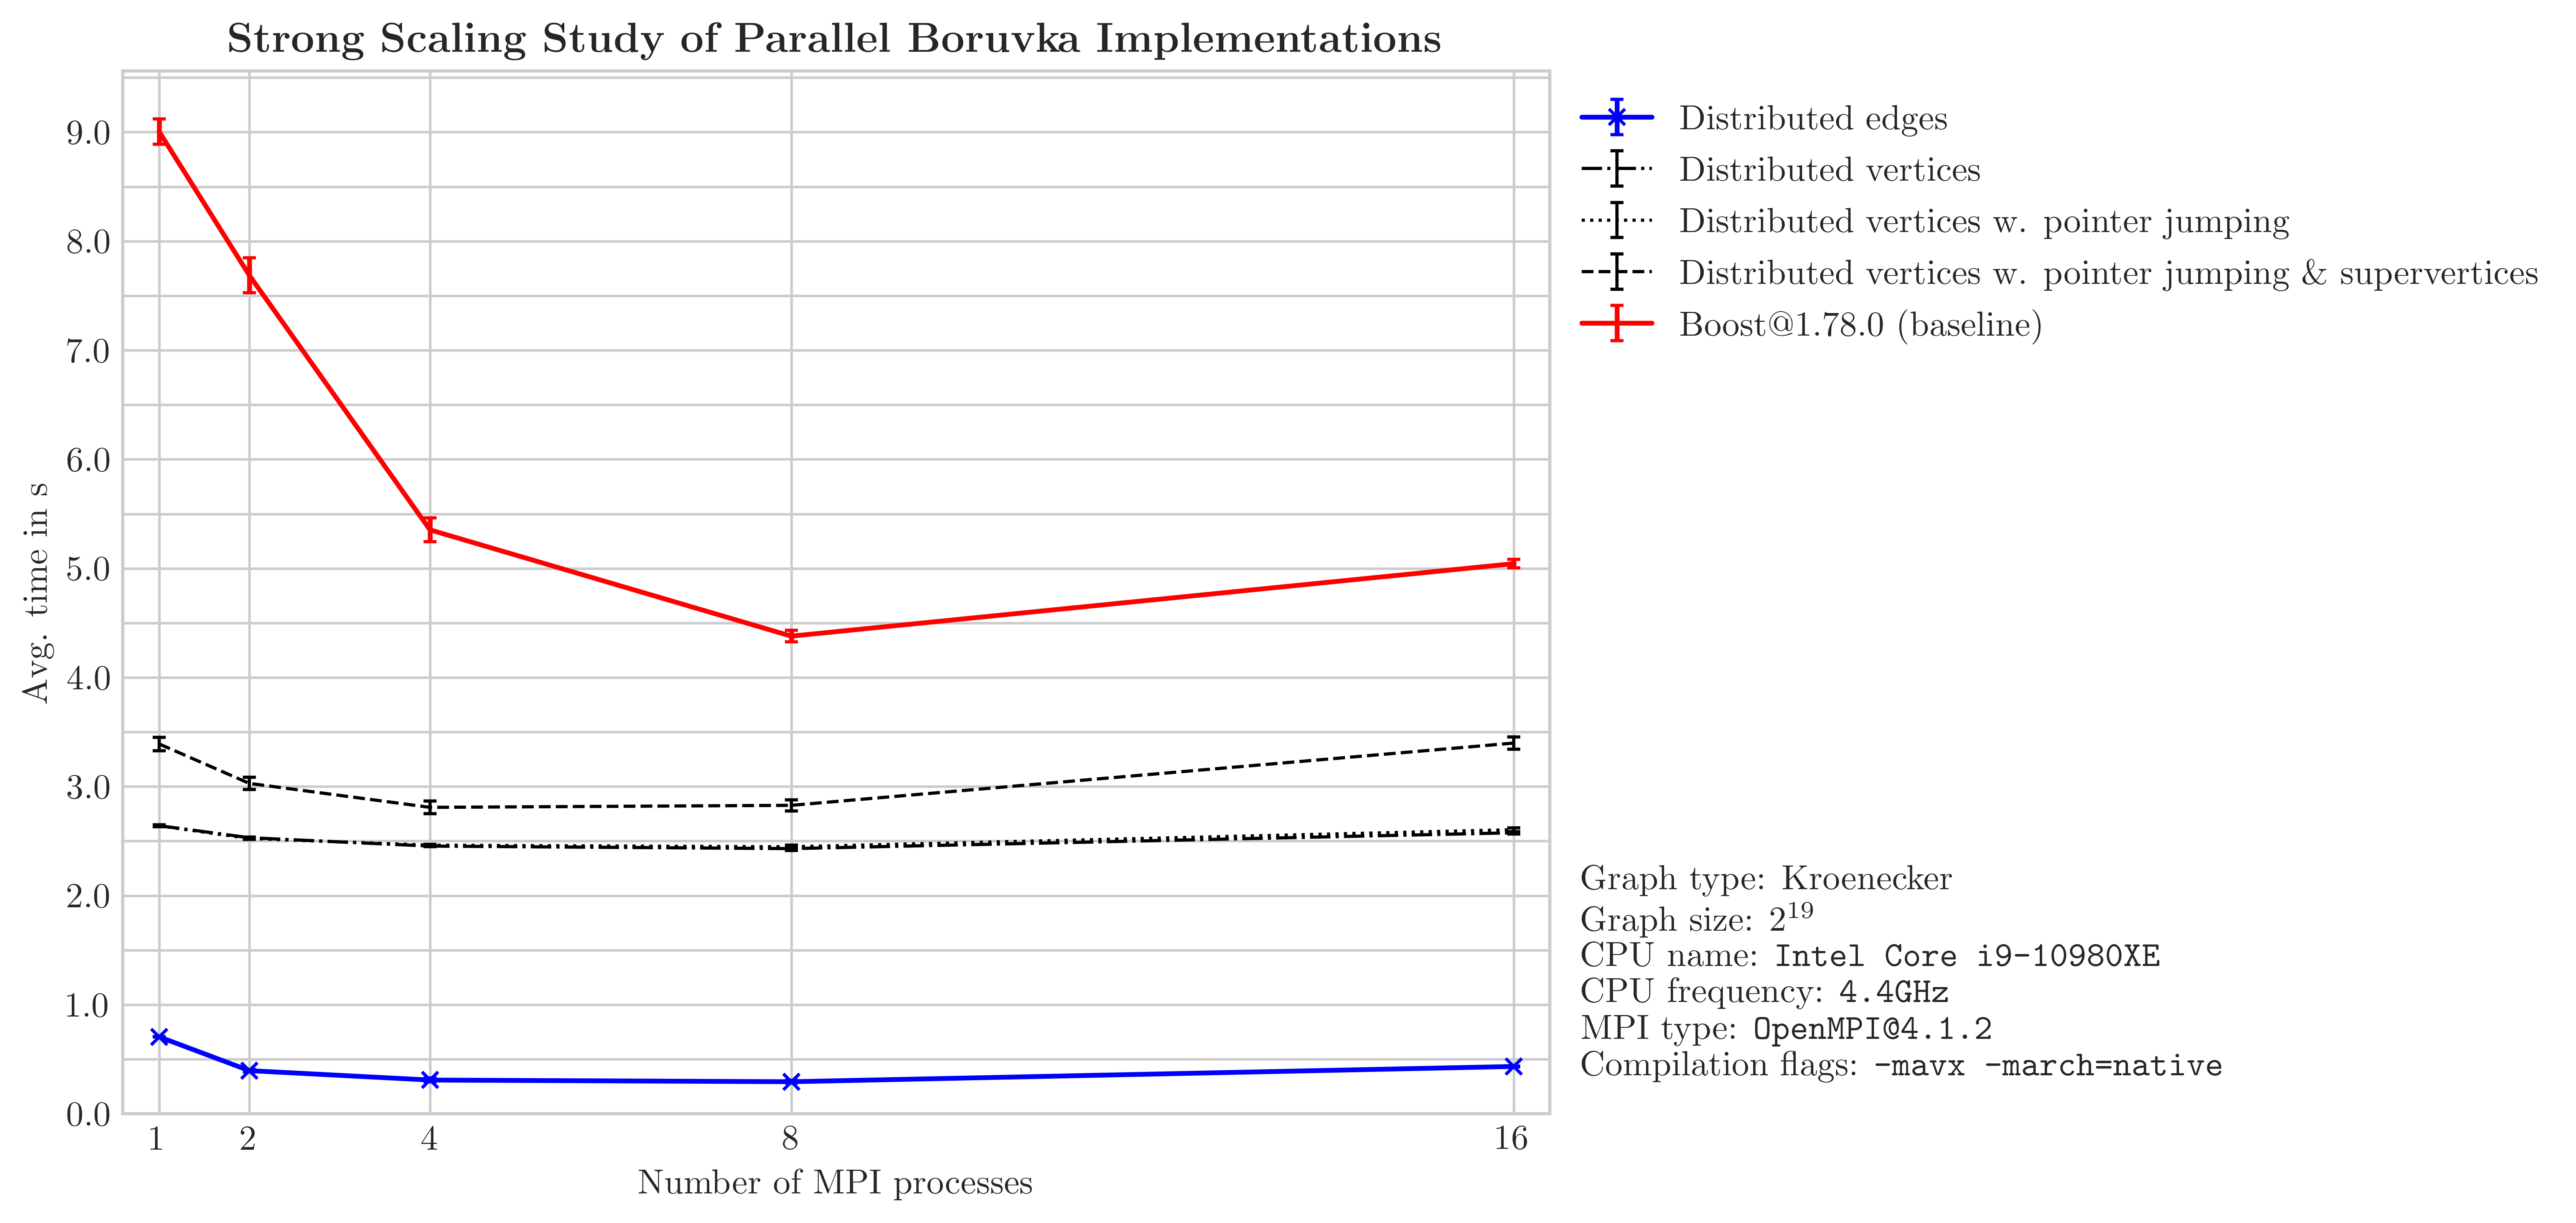

In [107]:
fig, ax = plt.subplots(figsize=FIGSIZE)

xticks = sorted(set(df_strongscaling.cores))
ax.set_xticks(xticks)
ax.set_xlim([min(xticks)-0.4, max(xticks)+0.4])
max_time = df_strongscaling.loc[:, 'm1':].to_numpy().max()
ax.set_yticks(np.arange(0, np.ceil(max_time), 0.5))
ax.set_ylim([0,np.mean([max_time,np.ceil(max_time)])])
for label in ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

for alg in set(df_strongscaling.algorithm):
    x = res_strongscaling[alg].index
    y = res_strongscaling[alg]['mean']
    ax.errorbar(x, y, yerr=res_strongscaling[alg]['double_std'],label=tex_escape(ALGORITHMS[alg]),**LINE_STYLES[alg],capsize=2);

ax.set(xlabel="Number of MPI processes",ylabel=r"Avg. time in $\mathrm{s}$",title=r"\textbf{Strong Scaling Study of Parallel Boruvka Implementations}")
legend = plt.legend(loc='upper left',bbox_to_anchor=(1.,1.))
legend._legend_box.align = "left"

ax.add_artist(AnchoredText(
    r"Graph type: Kroenecker""\n"
    r"Graph size: $2^{19}$""\n"
    r"CPU name: \texttt{Intel Core i9-10980XE}""\n"
    r"CPU frequency: \texttt{4.4GHz}""\n"
    r"MPI type: \texttt{OpenMPI@4.1.2}""\n"
    r"Compilation flags: \texttt{-mavx -march=native}",loc='lower left'
    ,bbox_to_anchor=(1.,0.),bbox_transform=ax.transAxes,frameon=False))

fig.savefig('strongscaling.png',bbox_inches='tight')
del fig, ax, xticks, legend

## 2. Comparison

In [19]:
df_comparison = pd.read_csv(FILES_PATH['comparison'])
df_comparison.head(5)

,algorithm,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10
0,0,0.3158,0.2988,0.3014,0.2961,0.2869,0.2874,0.2877,0.2881,0.2875,0.2874
1,2,2.4558,2.4381,2.4253,2.4211,2.4243,2.4211,2.4227,2.4228,2.4269,2.4228
2,3,2.4708,2.4585,2.4411,2.4486,2.4510,2.4511,2.4534,2.4514,2.4491,2.4472
3,4,2.8220,2.8887,2.8194,2.8300,2.7939,2.8258,2.8220,2.8328,2.8037,2.8342
4,5,4.4368,4.4209,4.3985,4.3909,4.3741,4.3905,4.3897,4.3939,4.3998,4.3611


TODO: improve grouby double std

In [71]:
grouped_comparison = df_comparison.set_index(['algorithm']).stack()
res_comparison = {alg : grouped_comparison[alg].agg([np.mean, np.std]) for alg in set(df_comparison.algorithm)}

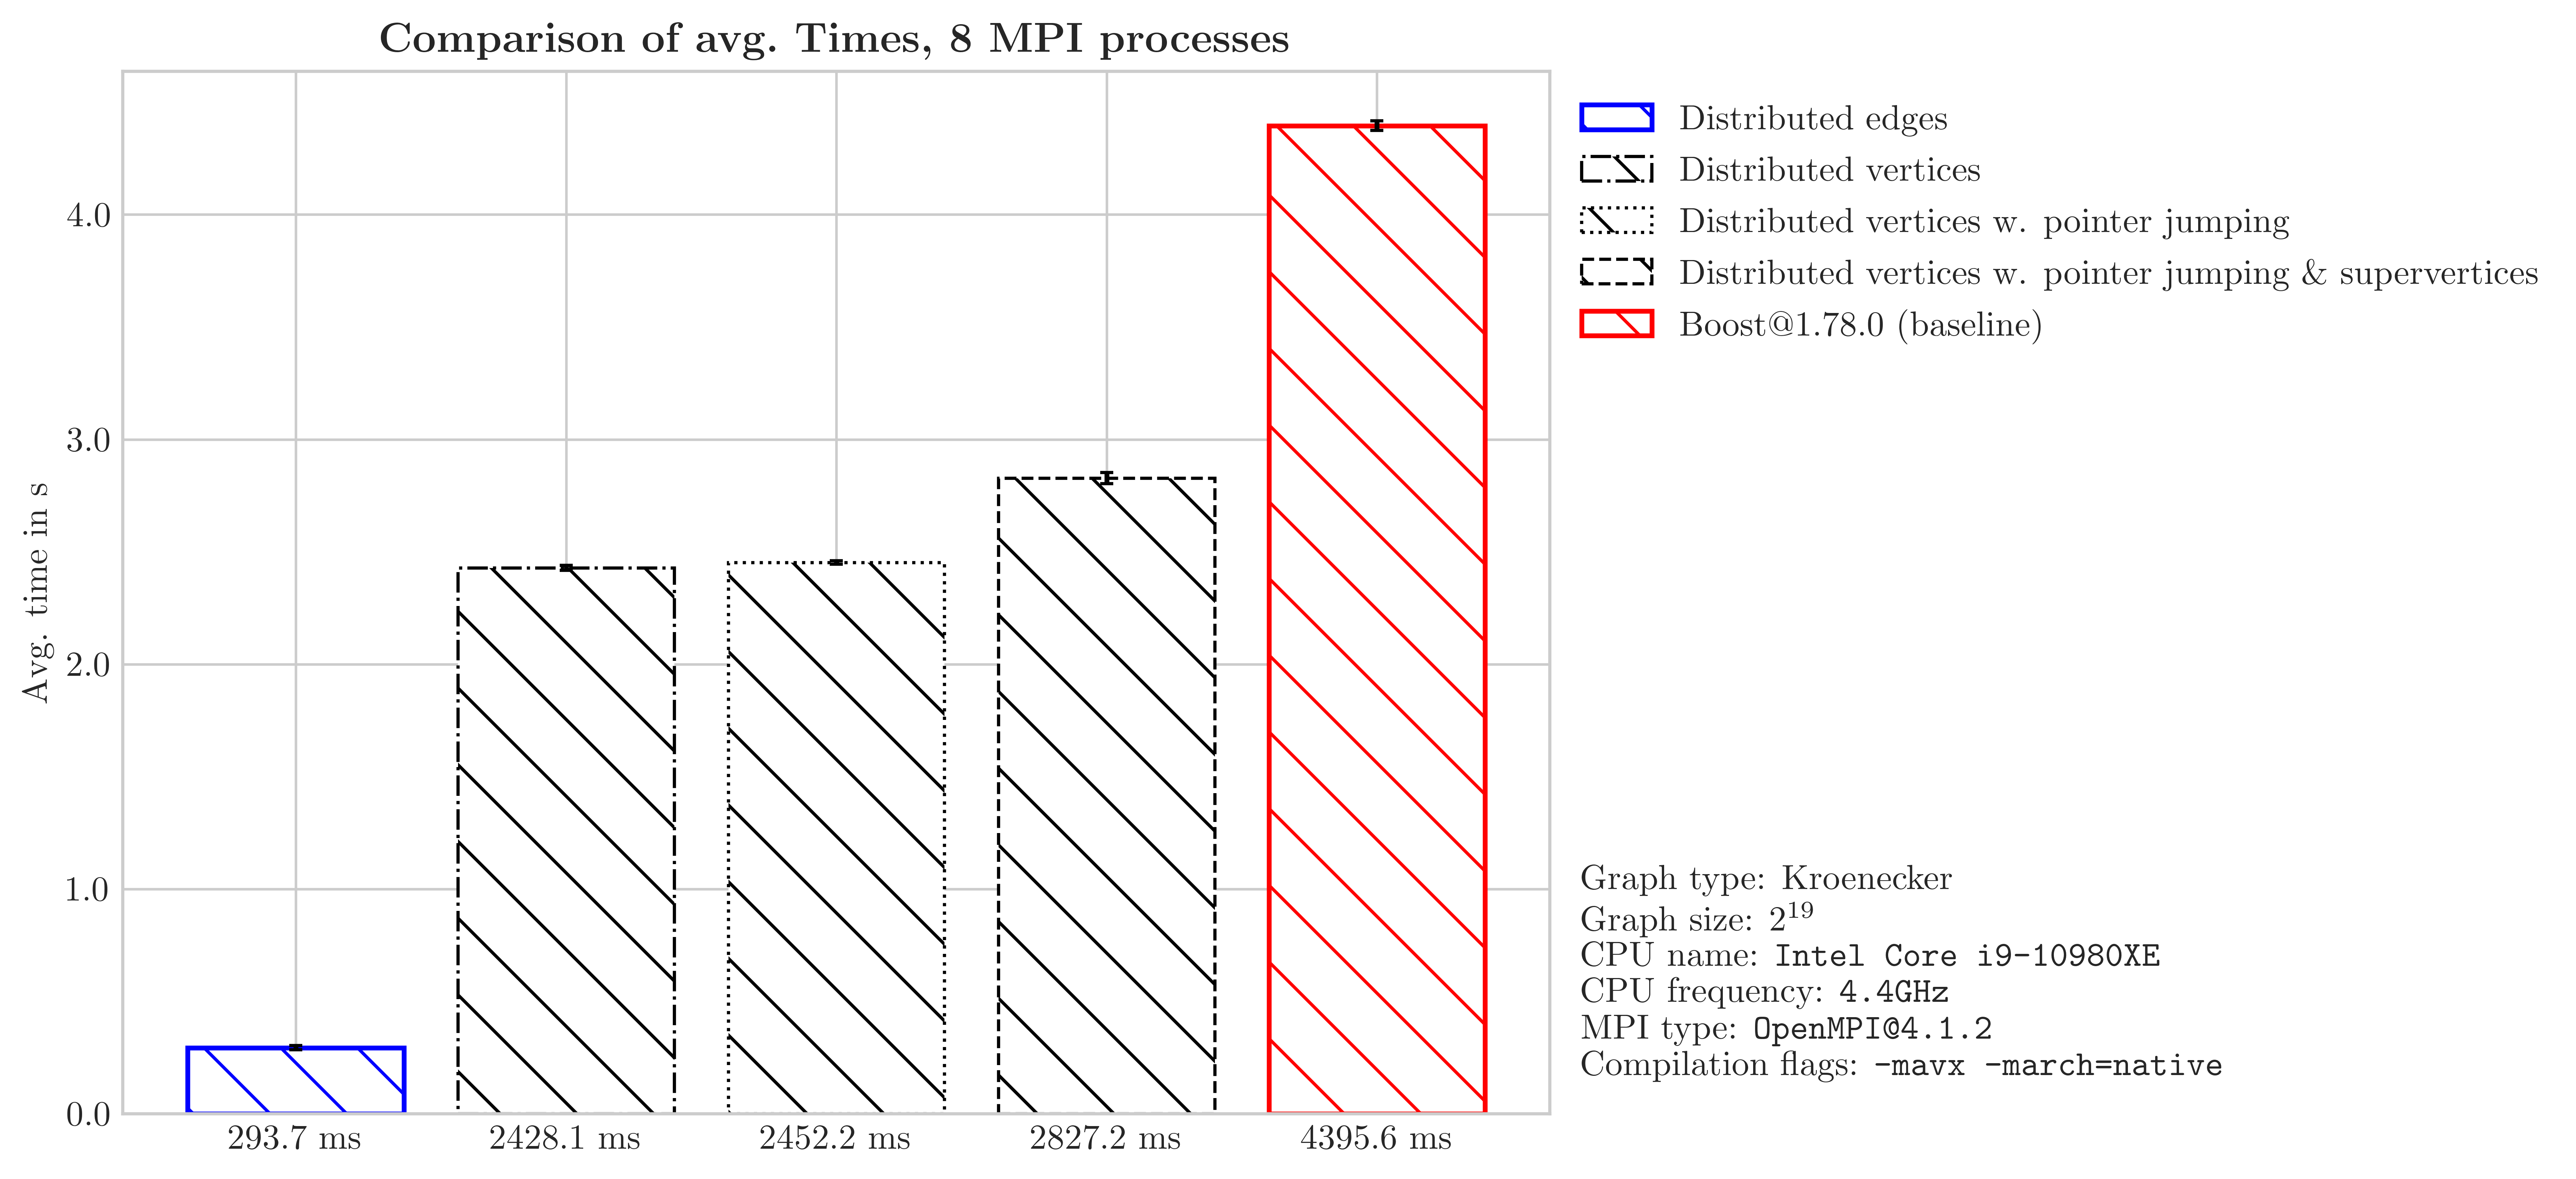

In [132]:
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

for alg in set(df_comparison.algorithm):
    x = f"{res_comparison[alg]['mean']*1000:.1f} ms"
    y = res_comparison[alg]['mean']
    ax.bar(x, y, yerr=res_comparison[alg]['std'],label=tex_escape(ALGORITHMS[alg]),**BAR_STYLES[alg],capsize=2);

ax.set(ylabel=r"Avg. time in $\mathrm{s}$",title=r"\textbf{Comparison of avg.\ Times, 8 MPI processes}")

ax.add_artist(AnchoredText(
    r"Graph type: Kroenecker""\n"
    r"Graph size: $2^{19}$""\n"
    r"CPU name: \texttt{Intel Core i9-10980XE}""\n"
    r"CPU frequency: \texttt{4.4GHz}""\n"
    r"MPI type: \texttt{OpenMPI@4.1.2}""\n"
    r"Compilation flags: \texttt{-mavx -march=native}",loc='lower left'
    ,bbox_to_anchor=(1.,0.),bbox_transform=ax.transAxes,frameon=False))

legend = plt.legend(loc='upper left',bbox_to_anchor=(1.,1.))
legend._legend_box.align = "left"

fig.savefig('comparison.png',bbox_inches='tight')
plt.show()

## 3. Weak Scaling

In [14]:
df_weakscaling = pd.read_csv(FILES_PATH['weakscaling'])
df_weakscaling.head(5)

,algorithm,graph_size,cores,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10
0,0,15,1,0.022837,0.022236,0.020819,0.020773,0.020807,0.020735,0.020781,0.020754,0.020704,0.020759
1,0,16,4,0.022900,0.020800,0.018000,0.018100,0.018000,0.018000,0.018200,0.018200,0.018200,0.018300
2,0,17,16,0.064100,0.064400,0.064300,0.064500,0.064800,0.064800,0.064700,0.064700,0.065100,0.064500
3,2,15,1,0.103341,0.103160,0.098166,0.098022,0.098281,0.098169,0.098083,0.098074,0.098221,0.098260
4,2,16,4,0.242100,0.235700,0.236400,0.233900,0.234300,0.234100,0.235200,0.235500,0.234100,0.234300


In [15]:
grouped_weakscaling = df_weakscaling.drop('graph_size', axis=1).set_index(['algorithm', 'cores']).stack()
res_weakscaling = {alg : grouped_weakscaling[alg].groupby('cores').agg([np.mean, double_std]) for alg in set(df_weakscaling.algorithm)}

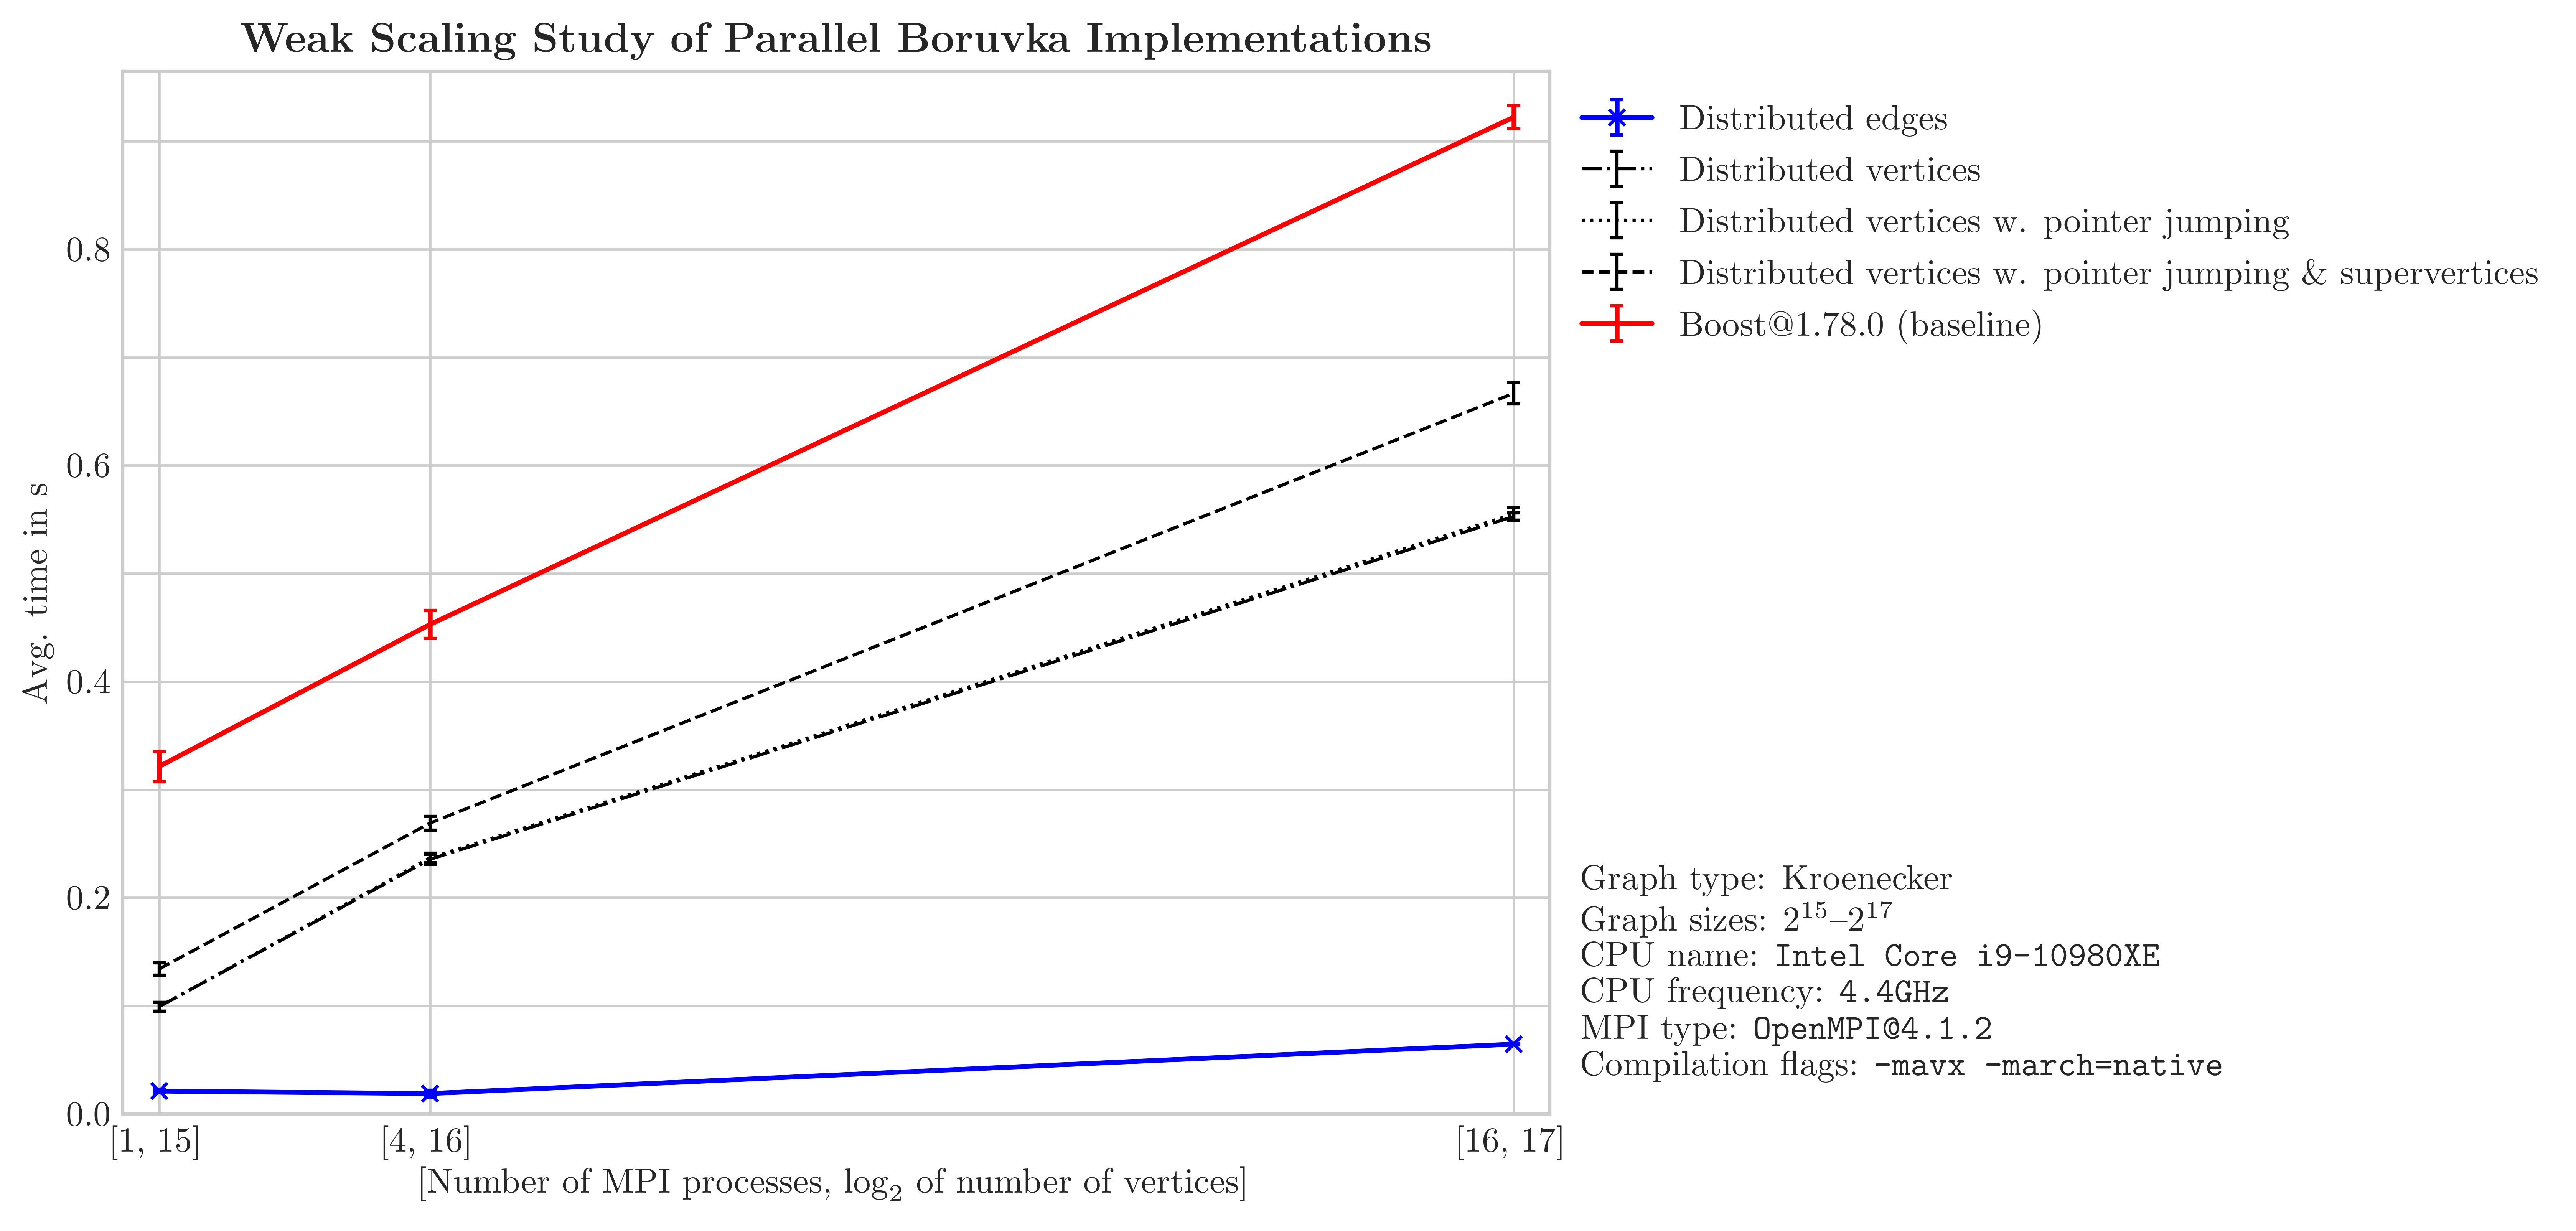

In [16]:
fig, ax = plt.subplots(figsize=FIGSIZE)

xticks = sorted(set(df_weakscaling.cores))
ax.set_xticks(xticks)
ax.set_xlim([min(xticks)-0.4, max(xticks)+0.4])
max_time = df_weakscaling.loc[:, 'm1':].to_numpy().max()
ax.set_yticks(np.arange(0, np.ceil(max_time), 0.1))
ax.set_ylim([0,np.mean([max_time,np.ceil(max_time)])])
for label in ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
    
xlabels = [f'[{x}, {15 + i}]' for i, x in enumerate(ax.get_xticks())]
ax.set_xticklabels(xlabels)

for alg in set(df_strongscaling.algorithm):
    x = res_weakscaling[alg].index
    y = res_weakscaling[alg]['mean']
    ax.errorbar(x, y, yerr=res_weakscaling[alg]['double_std'],label=tex_escape(ALGORITHMS[alg]),**LINE_STYLES[alg],capsize=2);

ax.set(xlabel="[Number of MPI processes, $\log_2$ of number of vertices]",ylabel=r"Avg. time in $\mathrm{s}$",title=r"\textbf{Weak Scaling Study of Parallel Boruvka Implementations}")
legend = plt.legend(loc='upper left',bbox_to_anchor=(1.,1.))
legend._legend_box.align = "left"

ax.add_artist(AnchoredText(
    r"Graph type: Kroenecker""\n"
    r"Graph sizes: $2^{15}$--$2^{17}$""\n"
    r"CPU name: \texttt{Intel Core i9-10980XE}""\n"
    r"CPU frequency: \texttt{4.4GHz}""\n"
    r"MPI type: \texttt{OpenMPI@4.1.2}""\n"
    r"Compilation flags: \texttt{-mavx -march=native}",loc='lower left'
    ,bbox_to_anchor=(1.,0.),bbox_transform=ax.transAxes,frameon=False))

fig.savefig('weakscaling.png',bbox_inches='tight')
del fig, ax, xticks, legend